<a href="https://colab.research.google.com/github/RobertFlan02/Dietetics-FYP/blob/main/Dietetics-FYP/Experiments/DeepLab/Experiment%205/DeeLabExperiment5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install bayesian-optimization -q

In [ ]:
!kaggle datasets download -d eather00/eduardopachecofoodseg103

Dataset URL: https://www.kaggle.com/datasets/eather00/eduardopachecofoodseg103
License(s): apache-2.0
100% 1.16G/1.16G [00:49<00:00, 28.1MB/s]
100% 1.16G/1.16G [00:49<00:00, 25.1MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('eduardopachecofoodseg103.zip', 'r') as zip_ref:
    zip_ref.extractall('foodseg103')

The key changes for this iteration of the Baysian optimization is we have both drastically increased the amount of epochs it is run for aswell as the amount of sample data it looks at in order to get more accurate results as well as adding the following

 **Additional Hyperparameters:**

**unfreeze_frac:** A value between 0 and 1 that controls what fraction of the backbone’s layers are unfrozen (so that later training can fine‑tune higher‐level features).

**– cls_loss_weight:** A weight for an auxiliary multi‑label classification loss that penalizes over‑prediction of food items. This loss is computed by comparing the predicted global class distribution (computed by averaging the segmentation softmax over pixels, ignoring background) with a target distribution (derived from the ground‑truth mask).

**Additional Loss Term (Classification Loss):**
This loss encourages the model to predict a class distribution closer to the true set of food items present.

**Backbone Fine‑Tuning:**
Instead of freezing the entire backbone, we now unfreeze a fraction (as given by unfreeze_frac) of its later layers.

In [ ]:
# ==============================
# Imports
# ==============================
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from bayes_opt import BayesianOptimization

# ==============================
# Helper Functions & Classes
# ==============================

def compute_metrics_from_confusion(conf_matrix):
    """Compute pixel accuracy, mean IoU, and mean Dice from a confusion matrix."""
    pixel_acc = np.trace(conf_matrix) / conf_matrix.sum() if conf_matrix.sum() > 0 else 0
    iou_list = []
    dice_list = []
    for i in range(conf_matrix.shape[0]):
        intersection = conf_matrix[i, i]
        union = conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i]
        if union == 0:
            iou = np.nan
            dice = np.nan
        else:
            iou = intersection / union
            dice = 2 * intersection / (conf_matrix[i, :].sum() + conf_matrix[:, i].sum())
        iou_list.append(iou)
        dice_list.append(dice)
    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    return pixel_acc, mean_iou, mean_dice

def dice_loss_fn(pred, target, smooth=1e-6):
    """
    Computes Dice loss.
      - pred: logits from the model, shape [N, C, H, W]
      - target: ground truth labels, shape [N, H, W]
    """
    pred = torch.softmax(pred, dim=1)
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])\
                           .permute(0, 3, 1, 2).float().to(pred.device)
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def classification_loss_fn(outputs, masks, num_classes):
    """
    Computes a KL divergence loss between the predicted global class distribution (ignoring background)
    and the target distribution derived from the mask.
    """
    p_pred = torch.softmax(outputs, dim=1).mean(dim=[2,3])  # [N, C]
    p_pred = p_pred[:, 1:]  # ignore background
    N = masks.size(0)
    target = torch.zeros((N, num_classes - 1), device=masks.device)
    masks_np = masks.cpu().numpy()
    for i in range(N):
        unique = np.unique(masks_np[i])
        for cls in unique:
            cls = int(cls)
            if cls > 0:
                target[i, cls - 1] = 1
        s = target[i].sum()
        if s > 0:
            target[i] /= s
    loss_cls = nn.functional.kl_div(p_pred.log(), target, reduction='batchmean')
    return loss_cls

def boundary_loss_fn(pred, target):
    """
    Computes a simple boundary loss using a Laplacian operator.
    - pred: logits from the model, shape [N, C, H, W]
    - target: ground truth labels, shape [N, H, W]
    """
    pred = torch.softmax(pred, dim=1)  # [N, C, H, W]
    # Define a 3x3 Laplacian kernel.
    laplacian_kernel = torch.tensor([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=pred.dtype, device=pred.device).view(1,1,3,3)
    boundaries_pred = []
    for c in range(pred.shape[1]):
        channel_pred = pred[:, c:c+1, :, :]
        boundary_c = torch.abs(torch.nn.functional.conv2d(channel_pred, laplacian_kernel, padding=1))
        boundaries_pred.append(boundary_c)
    boundaries_pred = torch.cat(boundaries_pred, dim=1)  # [N, C, H, W]

    target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])\
                           .permute(0, 3, 1, 2).float().to(pred.device)
    boundaries_target = []
    for c in range(target_one_hot.shape[1]):
        channel_target = target_one_hot[:, c:c+1, :, :]
        boundary_c = torch.abs(torch.nn.functional.conv2d(channel_target, laplacian_kernel, padding=1))
        boundaries_target.append(boundary_c)
    boundaries_target = torch.cat(boundaries_target, dim=1)

    loss_boundary = torch.nn.functional.l1_loss(boundaries_pred, boundaries_target)
    return loss_boundary

class JointTransform:
    def __init__(self, flip_prob=0.5, rotation_degrees=0):
        self.flip_prob = flip_prob
        self.rotation_degrees = rotation_degrees

    def __call__(self, img, mask):
        if np.random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        if self.rotation_degrees:
            angle = np.random.uniform(-self.rotation_degrees, self.rotation_degrees)
            img = transforms.functional.rotate(img, angle, interpolation=Image.BILINEAR, expand=True)
            mask = transforms.functional.rotate(mask, angle, interpolation=Image.NEAREST, expand=True)
        return img, mask

class FoodSegDataset(Dataset):
    def __init__(self, dataframe, img_transform=None, mask_resize=None, joint_transform=None):
        self.df = dataframe
        self.img_transform = img_transform
        self.mask_resize = mask_resize
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_dict = row['image']
        img = Image.open(io.BytesIO(image_dict.get("bytes"))).convert("RGB")
        label_dict = row['label']
        mask = Image.open(io.BytesIO(label_dict.get("bytes")))
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        if self.mask_resize:
            mask = self.mask_resize(mask)
        if self.img_transform:
            img = self.img_transform(img)
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

# ==============================
# Data Loading
# ==============================
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

train_files = [
    '/content/foodseg103/train-00000-of-00003-6bb37ec387d1825a.parquet',
    '/content/foodseg103/train-00001-of-00003-4a1caa37147c0681.parquet',
    '/content/foodseg103/train-00002-of-00003-c8b698399244cd95.parquet'
]
train_dfs = [pd.read_parquet(f) for f in train_files]
full_train_df = pd.concat(train_dfs, ignore_index=True)
print("Full training data shape:", full_train_df.shape)

train_df, test_df = train_test_split(full_train_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

# Increase subset size for Bayesian evaluation.
train_df_small = train_df.head(500)   # 500 training samples
test_df_small = test_df.head(200)       # 200 test samples

# ==============================
# Bayesian Optimization Objective Function
# ==============================
def train_evaluate(learning_rate, flip_prob, rotation_degrees, img_scale, weight_decay,
                   dice_weight, cls_loss_weight, unfreeze_frac, boundary_loss_weight):
    """
    Trains DeepLabV3 on a small subset for a few epochs with the given hyperparameters,
    then returns the mean IoU (mIoU) from the validation set.
    """
    rotation_degrees = int(round(rotation_degrees))
    effective_img_size = (int(round(513 * img_scale)), int(round(513 * img_scale)))

    local_hparams = {
        "img_size": effective_img_size,
        "batch_size": 4,
        "num_epochs": 5,  # Increased epochs for better convergence.
        "learning_rate": learning_rate,
        "num_workers": 1,
        "num_classes": 104,
        "use_amp": True,
        "flip_prob": flip_prob,
        "rotation_degrees": rotation_degrees,
        "weight_decay": weight_decay,
        "dice_weight": dice_weight,
        "cls_loss_weight": cls_loss_weight,
        "unfreeze_frac": unfreeze_frac,
        "boundary_loss_weight": boundary_loss_weight
    }

    img_transform_local = transforms.Compose([
        transforms.Resize(local_hparams["img_size"]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    mask_resize_local = transforms.Resize(local_hparams["img_size"], interpolation=Image.NEAREST)
    joint_transform_local = JointTransform(
        flip_prob=local_hparams["flip_prob"],
        rotation_degrees=local_hparams["rotation_degrees"]
    )

    train_dataset_local = FoodSegDataset(train_df_small,
                                         img_transform=img_transform_local,
                                         mask_resize=mask_resize_local,
                                         joint_transform=joint_transform_local)
    train_loader_local = DataLoader(train_dataset_local,
                                    batch_size=local_hparams["batch_size"],
                                    shuffle=True,
                                    num_workers=local_hparams["num_workers"])

    test_dataset_local = FoodSegDataset(test_df_small,
                                        img_transform=img_transform_local,
                                        mask_resize=mask_resize_local,
                                        joint_transform=None)
    test_loader_local = DataLoader(test_dataset_local,
                                   batch_size=local_hparams["batch_size"],
                                   shuffle=False,
                                   num_workers=local_hparams["num_workers"])

    # ------------------------------
    # Build DeepLabV3 Model
    # ------------------------------
    model_local = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    # Initially freeze entire backbone.
    for param in model_local.backbone.parameters():
        param.requires_grad = False
    # Unfreeze the last fraction of backbone layers.
    unfreeze_frac = local_hparams["unfreeze_frac"]
    children = list(model_local.backbone.children())
    n_children = len(children)
    n_unfreeze = int(unfreeze_frac * n_children)
    print(f"[BO] Unfreezing last {n_unfreeze} layers out of {n_children} in backbone.")
    if n_unfreeze > 0:
        for child in children[-n_unfreeze:]:
            for param in child.parameters():
                param.requires_grad = True

    model_local.classifier[4] = nn.Conv2d(256, local_hparams["num_classes"], kernel_size=1)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_local = model_local.to(device)

    criterion_local = nn.CrossEntropyLoss()
    optimizer_local = optim.Adam(filter(lambda p: p.requires_grad, model_local.parameters()),
                                 lr=local_hparams["learning_rate"],
                                 weight_decay=local_hparams["weight_decay"])
    scheduler_local = ReduceLROnPlateau(optimizer_local, mode='min', factor=0.5, patience=1, verbose=False)
    scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None

    # ------------------------------
    # Training Loop
    # ------------------------------
    model_local.train()
    for epoch in range(local_hparams["num_epochs"]):
        for images, masks in train_loader_local:
            images = images.to(device)
            masks = masks.to(device)
            optimizer_local.zero_grad()
            if scaler_local is not None:
                with torch.cuda.amp.autocast():
                    outputs = model_local(images)['out']
                    loss_ce = criterion_local(outputs, masks)
                    loss_dice = dice_loss_fn(outputs, masks)
                    loss_cls = classification_loss_fn(outputs, masks, local_hparams["num_classes"])
                    loss_boundary = boundary_loss_fn(outputs, masks)
                    loss = loss_ce + local_hparams["dice_weight"] * loss_dice \
                           + local_hparams["cls_loss_weight"] * loss_cls \
                           + local_hparams["boundary_loss_weight"] * loss_boundary
                scaler_local.scale(loss).backward()
                scaler_local.step(optimizer_local)
                scaler_local.update()
            else:
                outputs = model_local(images)['out']
                loss_ce = criterion_local(outputs, masks)
                loss_dice = dice_loss_fn(outputs, masks)
                loss_cls = classification_loss_fn(outputs, masks, local_hparams["num_classes"])
                loss_boundary = boundary_loss_fn(outputs, masks)
                loss = loss_ce + local_hparams["dice_weight"] * loss_dice \
                           + local_hparams["cls_loss_weight"] * loss_cls \
                           + local_hparams["boundary_loss_weight"] * loss_boundary
                loss.backward()
                optimizer_local.step()
        scheduler_local.step(loss.item())

    # ------------------------------
    # Evaluation Loop
    # ------------------------------
    model_local.eval()
    test_conf_matrix = np.zeros((local_hparams["num_classes"], local_hparams["num_classes"]), dtype=np.int64)
    with torch.no_grad():
        for images, masks in test_loader_local:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model_local(images)['out']
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            targets = masks.detach().cpu().numpy()
            preds_flat = preds.flatten()
            targets_flat = targets.flatten()
            batch_conf = np.bincount(
                local_hparams["num_classes"] * targets_flat + preds_flat,
                minlength=local_hparams["num_classes"]**2
            ).reshape(local_hparams["num_classes"], local_hparams["num_classes"])
            test_conf_matrix += batch_conf

    _, test_mean_iou, _ = compute_metrics_from_confusion(test_conf_matrix)
    return test_mean_iou

# ==============================
# Bayesian Optimization Setup
# ==============================
# New hyperparameters "unfreeze_frac", "cls_loss_weight", and "boundary_loss_weight" are added.
# Narrowed search space based on previous best results:
pbounds = {
    'learning_rate': (0.0006, 0.0008),
    'flip_prob': (0.2, 0.4),
    'rotation_degrees': (10, 20),
    'img_scale': (0.82, 0.98),
    'weight_decay': (1e-4, 2e-4),
    'dice_weight': (0.7, 1.0),
    'cls_loss_weight': (0.2, 1.0),
    'unfreeze_frac': (0.2, 0.4),
    'boundary_loss_weight': (0.1, 0.5)
}

optimizer_bo = BayesianOptimization(
    f=train_evaluate,
    pbounds=pbounds,
    random_state=42,
)

print("Starting Bayesian Optimization...")
optimizer_bo.maximize(
    init_points=5,  # Number of random initial points.
    n_iter=10       # Number of optimization iterations.
)

print("Best result found:")
print(optimizer_bo.max)


Full training data shape: (4983, 2)
Training set shape: (3986, 2)
Testing set shape: (997, 2)
Starting Bayesian Optimization...
|   iter    |  target   | bounda... | cls_lo... | dice_w... | flip_prob | img_scale | learni... | rotati... | unfree... | weight... |
-------------------------------------------------------------------------------------------------------------------------------------


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 250MB/s]


[BO] Unfreezing last 2 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 1         | 0.03271   | 0.2498    | 0.9606    | 0.9196    | 0.3197    | 0.845     | 0.0006312 | 10.58     | 0.3732    | 0.0001601 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[BO] Unfreezing last 2 layers out of 8 in backbone.
| 2         | 0.0291    | 0.3832    | 0.2165    | 0.991     | 0.3665    | 0.854     | 0.0006364 | 11.83     | 0.2608    | 0.0001525 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[BO] Unfreezing last 2 layers out of 8 in backbone.
| 3         | 0.0419    | 0.2728    | 0.433     | 0.8836    | 0.2279    | 0.8667    | 0.0006733 | 14.56     | 0.357     | 0.00012   |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[BO] Unfreezing last 3 layers out of 8 in backbone.
| 4         | 0.01905   | 0.3057    | 0.6739    | 0.7139    | 0.3215    | 0.8473    | 0.000613  | 19.49     | 0.3931    | 0.0001808 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


[BO] Unfreezing last 3 layers out of 8 in backbone.
| 5         | 0.02247   | 0.2218    | 0.2781    | 0.9053    | 0.288     | 0.8395    | 0.000699  | 10.34     | 0.3819    | 0.0001259 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 3 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 6         | 0.01608   | 0.4843    | 0.6821    | 0.9972    | 0.2865    | 0.8252    | 0.0006605 | 16.51     | 0.3821    | 0.0001615 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 3 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 7         | 0.01881   | 0.4043    | 0.7818    | 0.8885    | 0.2151    | 0.8652    | 0.0006856 | 10.23     | 0.3934    | 0.000121  |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 2 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 8         | 0.0271    | 0.2753    | 0.9632    | 0.7554    | 0.3868    | 0.8908    | 0.0006521 | 16.08     | 0.2808    | 0.0001398 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 1 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 9         | 0.04357   | 0.1504    | 0.3955    | 0.9282    | 0.2055    | 0.9529    | 0.0006345 | 18.63     | 0.2332    | 0.0001345 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 1 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 10        | 0.04511   | 0.4862    | 0.7148    | 0.7964    | 0.352     | 0.8394    | 0.0006801 | 19.42     | 0.244     | 0.000134  |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 3 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 11        | 0.02104   | 0.4555    | 0.5335    | 0.7049    | 0.2165    | 0.9653    | 0.0007122 | 17.55     | 0.3958    | 0.0001023 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 1 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 12        | 0.04728   | 0.1577    | 0.4121    | 0.9919    | 0.3935    | 0.9208    | 0.0006216 | 18.69     | 0.2024    | 0.0001919 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 2 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 13        | 0.02508   | 0.2743    | 0.9894    | 0.7031    | 0.3547    | 0.9721    | 0.000754  | 18.62     | 0.3348    | 0.0001075 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 2 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 14        | 0.02804   | 0.2925    | 0.9306    | 0.8831    | 0.2596    | 0.9529    | 0.0007325 | 17.88     | 0.296     | 0.0001506 |


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[BO] Unfreezing last 2 layers out of 8 in backbone.


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-5-af229877f77a>:262: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_local = torch.cuda.amp.GradScaler() if local_hparams["use_amp"] and device.type == 'cuda' else None
<ipython-input-5-af229877f77a>:274: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


| 15        | 0.02646   | 0.2234    | 0.4713    | 0.9854    | 0.2779    | 0.9734    | 0.0007501 | 18.69     | 0.2995    | 0.000155  |
Best result found:


TypeError: 'dict' object is not callable

The key changes to the training code is we have added a boundary loss term to help the model learn sharper edges and reduce over-prediction.

Using Hyperparameters:
  img_scale: 0.9208
  batch_size: 4
  num_epochs: 5
  learning_rate: 0.0006216
  weight_decay: 0.0001919
  num_workers: 1
  num_classes: 104
  use_amp: True
  flip_prob: 0.3935
  rotation_degrees: 18.69
  dice_weight: 0.9919
  cls_loss_weight: 0.4121
  unfreeze_frac: 0.2024
  boundary_loss_weight: 0.1577
  img_size: (472, 472)
Full training data shape: (4983, 2)
Training set shape: (3986, 2)
Testing set shape: (997, 2)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-6-13ea1be57894>:249: FutureWarning: `torch.cuda.amp.GradScaler(args...)`

Unfreezing last 1 layers out of 8 in backbone.


Epoch 1/5 [Training]:   0%|          | 0/997 [00:00<?, ?it/s]<ipython-input-6-13ea1be57894>:270: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/5 [Training]: 100%|██████████| 997/997 [29:31<00:00,  1.78s/it, loss=3.5116]


Epoch [1/5], Train Loss: 3.9067, Pixel Acc: 0.6504, mIoU: 0.0293, mDice: 0.0456


Epoch 1/5 [Testing]: 100%|██████████| 250/250 [02:35<00:00,  1.61it/s, loss=3.5552]


Epoch [1/5], Test Loss: 3.8107, Pixel Acc: 0.6002, mIoU: 0.0510, mDice: 0.0777
New best model found and saved with Test Loss: 3.8107


Epoch 2/5 [Training]: 100%|██████████| 997/997 [29:29<00:00,  1.77s/it, loss=3.3714]


Epoch [2/5], Train Loss: 3.4534, Pixel Acc: 0.6944, mIoU: 0.0647, mDice: 0.0998


Epoch 2/5 [Testing]: 100%|██████████| 250/250 [02:34<00:00,  1.62it/s, loss=3.1870]


Epoch [2/5], Test Loss: 3.5423, Pixel Acc: 0.6178, mIoU: 0.0809, mDice: 0.1223
New best model found and saved with Test Loss: 3.5423


Epoch 3/5 [Training]: 100%|██████████| 997/997 [29:23<00:00,  1.77s/it, loss=3.3243]


Epoch [3/5], Train Loss: 3.2869, Pixel Acc: 0.7112, mIoU: 0.0866, mDice: 0.1319


Epoch 3/5 [Testing]: 100%|██████████| 250/250 [02:33<00:00,  1.63it/s, loss=2.9280]


Epoch [3/5], Test Loss: 3.3626, Pixel Acc: 0.6519, mIoU: 0.1059, mDice: 0.1570
New best model found and saved with Test Loss: 3.3626


Epoch 4/5 [Training]: 100%|██████████| 997/997 [29:19<00:00,  1.76s/it, loss=3.2912]


Epoch [4/5], Train Loss: 3.1672, Pixel Acc: 0.7260, mIoU: 0.1049, mDice: 0.1577


Epoch 4/5 [Testing]: 100%|██████████| 250/250 [02:33<00:00,  1.63it/s, loss=3.5127]


Epoch [4/5], Test Loss: 3.2611, Pixel Acc: 0.6689, mIoU: 0.1259, mDice: 0.1837
New best model found and saved with Test Loss: 3.2611


Epoch 5/5 [Training]: 100%|██████████| 997/997 [29:16<00:00,  1.76s/it, loss=2.8940]


Epoch [5/5], Train Loss: 3.0790, Pixel Acc: 0.7348, mIoU: 0.1211, mDice: 0.1809


Epoch 5/5 [Testing]: 100%|██████████| 250/250 [02:33<00:00,  1.63it/s, loss=2.9947]


Epoch [5/5], Test Loss: 3.2324, Pixel Acc: 0.6665, mIoU: 0.1386, mDice: 0.2013
New best model found and saved with Test Loss: 3.2324


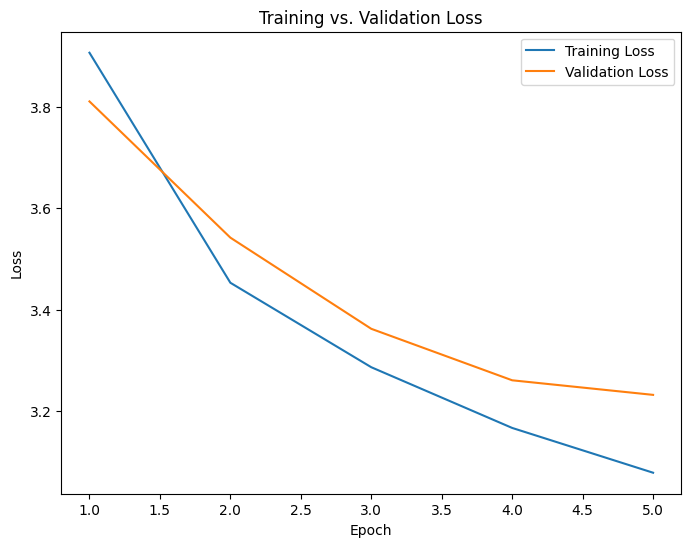

In [ ]:
import os
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# ------------------------------
# Hyperparameters (from Bayesian Optimization)
# ------------------------------
# These values are assumed to be chosen by the Bayesian optimizer.
OPT_HYPERPARAMS = {
    "img_scale": 0.9208,
    "batch_size": 4,
    "num_epochs": 5,
    "learning_rate": 0.0006216,
    "weight_decay": 0.0001919,
    "num_workers": 1,
    "num_classes": 104,
    "use_amp": True,
    "flip_prob": 0.3935,
    "rotation_degrees": 18.69,
    "dice_weight": 0.9919,
    "cls_loss_weight": 0.4121,
    "unfreeze_frac": 0.2024,
    "boundary_loss_weight": 0.1577
}
base_size = 513
OPT_HYPERPARAMS["img_size"] = (int(round(base_size * OPT_HYPERPARAMS["img_scale"])),
                                int(round(base_size * OPT_HYPERPARAMS["img_scale"])))

print("Using Hyperparameters:")
for key, value in OPT_HYPERPARAMS.items():
    print(f"  {key}: {value}")

# ------------------------------
# Helper Functions & Classes
# ------------------------------
def compute_metrics_from_confusion(conf_matrix):
    """Compute pixel accuracy, mean IoU, and mean Dice from a confusion matrix."""
    pixel_acc = np.trace(conf_matrix) / conf_matrix.sum() if conf_matrix.sum() > 0 else 0
    iou_list = []
    dice_list = []
    for i in range(conf_matrix.shape[0]):
        intersection = conf_matrix[i, i]
        union = conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i]
        if union == 0:
            iou = np.nan
            dice = np.nan
        else:
            iou = intersection / union
            dice = 2 * intersection / (conf_matrix[i, :].sum() + conf_matrix[:, i].sum())
        iou_list.append(iou)
        dice_list.append(dice)
    mean_iou = np.nanmean(iou_list)
    mean_dice = np.nanmean(dice_list)
    return pixel_acc, mean_iou, mean_dice

def dice_loss_fn(pred, target, smooth=1e-6):
    """
    Computes Dice loss.
      - pred: logits from the model, shape [N, C, H, W]
      - target: ground truth labels, shape [N, H, W]
    """
    pred = torch.softmax(pred, dim=1)
    target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])\
                           .permute(0, 3, 1, 2).float().to(pred.device)
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

def classification_loss_fn(outputs, masks, num_classes):
    """
    Computes a KL divergence loss between the predicted global class distribution (ignoring background)
    and the target distribution derived from the mask.
    """
    p_pred = torch.softmax(outputs, dim=1).mean(dim=[2,3])
    p_pred = p_pred[:, 1:]
    N = masks.size(0)
    target = torch.zeros((N, num_classes - 1), device=masks.device)
    masks_np = masks.cpu().numpy()
    for i in range(N):
        unique = np.unique(masks_np[i])
        for cls in unique:
            cls = int(cls)
            if cls > 0:
                target[i, cls - 1] = 1
        s = target[i].sum()
        if s > 0:
            target[i] /= s
    loss_cls = nn.functional.kl_div(p_pred.log(), target, reduction='batchmean')
    return loss_cls

def boundary_loss_fn(pred, target):
    """
    Computes a simple boundary loss using a Laplacian operator.
    - pred: logits from the model, shape [N, C, H, W]
    - target: ground truth labels, shape [N, H, W]
    """
    pred = torch.softmax(pred, dim=1)
    laplacian_kernel = torch.tensor([[0, 1, 0],
                                     [1, -4, 1],
                                     [0, 1, 0]], dtype=pred.dtype, device=pred.device).view(1,1,3,3)
    boundaries_pred = []
    for c in range(pred.shape[1]):
        channel_pred = pred[:, c:c+1, :, :]
        boundary_c = torch.abs(torch.nn.functional.conv2d(channel_pred, laplacian_kernel, padding=1))
        boundaries_pred.append(boundary_c)
    boundaries_pred = torch.cat(boundaries_pred, dim=1)

    target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])\
                           .permute(0, 3, 1, 2).float().to(pred.device)
    boundaries_target = []
    for c in range(target_one_hot.shape[1]):
        channel_target = target_one_hot[:, c:c+1, :, :]
        boundary_c = torch.abs(torch.nn.functional.conv2d(channel_target, laplacian_kernel, padding=1))
        boundaries_target.append(boundary_c)
    boundaries_target = torch.cat(boundaries_target, dim=1)

    loss_boundary = torch.nn.functional.l1_loss(boundaries_pred, boundaries_target)
    return loss_boundary

class JointTransform:
    def __init__(self, flip_prob=0.5, rotation_degrees=0):
        self.flip_prob = flip_prob
        self.rotation_degrees = rotation_degrees

    def __call__(self, img, mask):
        if np.random.random() < self.flip_prob:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)
        if self.rotation_degrees:
            angle = np.random.uniform(-self.rotation_degrees, self.rotation_degrees)
            img = transforms.functional.rotate(img, angle, interpolation=Image.BILINEAR, expand=True)
            mask = transforms.functional.rotate(mask, angle, interpolation=Image.NEAREST, expand=True)
        return img, mask

class FoodSegDataset(Dataset):
    def __init__(self, dataframe, img_transform=None, mask_resize=None, joint_transform=None):
        self.df = dataframe
        self.img_transform = img_transform
        self.mask_resize = mask_resize
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_dict = row['image']
        img = Image.open(io.BytesIO(image_dict.get("bytes"))).convert("RGB")
        label_dict = row['label']
        mask = Image.open(io.BytesIO(label_dict.get("bytes")))
        if self.joint_transform is not None:
            img, mask = self.joint_transform(img, mask)
        if self.mask_resize:
            mask = self.mask_resize(mask)
        if self.img_transform:
            img = self.img_transform(img)
        mask = torch.from_numpy(np.array(mask)).long()
        return img, mask

# ------------------------------
# Data Loading
# ------------------------------
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

train_files = [
    '/content/foodseg103/train-00000-of-00003-6bb37ec387d1825a.parquet',
    '/content/foodseg103/train-00001-of-00003-4a1caa37147c0681.parquet',
    '/content/foodseg103/train-00002-of-00003-c8b698399244cd95.parquet'
]
train_dfs = [pd.read_parquet(f) for f in train_files]
full_train_df = pd.concat(train_dfs, ignore_index=True)
print("Full training data shape:", full_train_df.shape)

train_df, test_df = train_test_split(full_train_df, test_size=0.2, random_state=42)
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

img_transform = transforms.Compose([
    transforms.Resize(OPT_HYPERPARAMS["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
mask_resize = transforms.Resize(OPT_HYPERPARAMS["img_size"], interpolation=Image.NEAREST)

joint_transform = JointTransform(
    flip_prob=OPT_HYPERPARAMS["flip_prob"],
    rotation_degrees=OPT_HYPERPARAMS["rotation_degrees"]
)

train_dataset = FoodSegDataset(train_df, img_transform=img_transform,
                               mask_resize=mask_resize, joint_transform=joint_transform)
train_loader = DataLoader(train_dataset, batch_size=OPT_HYPERPARAMS["batch_size"],
                          shuffle=True, num_workers=OPT_HYPERPARAMS["num_workers"])

test_dataset = FoodSegDataset(test_df, img_transform=img_transform,
                              mask_resize=mask_resize, joint_transform=None)
test_loader = DataLoader(test_dataset, batch_size=OPT_HYPERPARAMS["batch_size"],
                         shuffle=False, num_workers=OPT_HYPERPARAMS["num_workers"])

# ------------------------------
# Build Model
# ------------------------------
model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
# Initially freeze the backbone.
for param in model.backbone.parameters():
    param.requires_grad = False
# Unfreeze a fraction of backbone layers.
unfreeze_frac = OPT_HYPERPARAMS["unfreeze_frac"]
children = list(model.backbone.children())
n_children = len(children)
n_unfreeze = int(unfreeze_frac * n_children)
print(f"Unfreezing last {n_unfreeze} layers out of {n_children} in backbone.")
if n_unfreeze > 0:
    for child in children[-n_unfreeze:]:
        for param in child.parameters():
            param.requires_grad = True

model.classifier[4] = nn.Conv2d(256, OPT_HYPERPARAMS["num_classes"], kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ------------------------------
# Loss, Optimizer, Scheduler, and AMP Scaler
# ------------------------------
criterion = nn.CrossEntropyLoss()
dice_weight = OPT_HYPERPARAMS["dice_weight"]
cls_loss_weight = OPT_HYPERPARAMS["cls_loss_weight"]
boundary_loss_weight = OPT_HYPERPARAMS["boundary_loss_weight"]
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                       lr=OPT_HYPERPARAMS["learning_rate"],
                       weight_decay=OPT_HYPERPARAMS["weight_decay"])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)
scaler = torch.cuda.amp.GradScaler() if OPT_HYPERPARAMS["use_amp"] and device.type == 'cuda' else None

# ------------------------------
# Training and Validation Loop with Checkpointing
# ------------------------------
train_losses = []
val_losses = []
best_val_loss = float('inf')
model_save_path = "/content/foodseg103/best_deeplabv3_resnet50_foodseg103.pth"

for epoch in range(OPT_HYPERPARAMS["num_epochs"]):
    model.train()
    train_loss = 0.0
    train_conf_matrix = np.zeros((OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"]), dtype=np.int64)

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{OPT_HYPERPARAMS['num_epochs']} [Training]")
    for images, masks in train_bar:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        if scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(images)['out']
                loss_ce = criterion(outputs, masks)
                loss_dice = dice_loss_fn(outputs, masks)
                loss_cls = classification_loss_fn(outputs, masks, OPT_HYPERPARAMS["num_classes"])
                loss_boundary = boundary_loss_fn(outputs, masks)
                loss = loss_ce + dice_weight * loss_dice \
                       + cls_loss_weight * loss_cls \
                       + boundary_loss_weight * loss_boundary
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)['out']
            loss_ce = criterion(outputs, masks)
            loss_dice = dice_loss_fn(outputs, masks)
            loss_cls = classification_loss_fn(outputs, masks, OPT_HYPERPARAMS["num_classes"])
            loss_boundary = boundary_loss_fn(outputs, masks)
            loss = loss_ce + dice_weight * loss_dice \
                       + cls_loss_weight * loss_cls \
                       + boundary_loss_weight * loss_boundary
            loss.backward()
            optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(dim=1).detach().cpu().numpy()
        targets = masks.detach().cpu().numpy()
        preds_flat = preds.flatten()
        targets_flat = targets.flatten()
        batch_conf = np.bincount(
            OPT_HYPERPARAMS["num_classes"] * targets_flat + preds_flat,
            minlength=OPT_HYPERPARAMS["num_classes"]**2
        ).reshape(OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"])
        train_conf_matrix += batch_conf
        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_pixel_acc, train_mean_iou, train_mean_dice = compute_metrics_from_confusion(train_conf_matrix)
    print(f"Epoch [{epoch+1}/{OPT_HYPERPARAMS['num_epochs']}], Train Loss: {avg_train_loss:.4f}, Pixel Acc: {train_pixel_acc:.4f}, mIoU: {train_mean_iou:.4f}, mDice: {train_mean_dice:.4f}")

    model.eval()
    test_loss = 0.0
    test_conf_matrix = np.zeros((OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"]), dtype=np.int64)
    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{OPT_HYPERPARAMS['num_epochs']} [Testing]")
        for images, masks in test_bar:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)['out']
            loss_ce = criterion(outputs, masks)
            loss_dice = dice_loss_fn(outputs, masks)
            loss_cls = classification_loss_fn(outputs, masks, OPT_HYPERPARAMS["num_classes"])
            loss_boundary = boundary_loss_fn(outputs, masks)
            loss = loss_ce + dice_weight * loss_dice \
                       + cls_loss_weight * loss_cls \
                       + boundary_loss_weight * loss_boundary
            test_loss += loss.item()
            preds = outputs.argmax(dim=1).detach().cpu().numpy()
            targets = masks.detach().cpu().numpy()
            preds_flat = preds.flatten()
            targets_flat = targets.flatten()
            batch_conf = np.bincount(
                OPT_HYPERPARAMS["num_classes"] * targets_flat + preds_flat,
                minlength=OPT_HYPERPARAMS["num_classes"]**2
            ).reshape(OPT_HYPERPARAMS["num_classes"], OPT_HYPERPARAMS["num_classes"])
            test_conf_matrix += batch_conf
            test_bar.set_postfix(loss=f"{loss.item():.4f}")

    avg_test_loss = test_loss / len(test_loader)
    val_losses.append(avg_test_loss)
    test_pixel_acc, test_mean_iou, test_mean_dice = compute_metrics_from_confusion(test_conf_matrix)
    print(f"Epoch [{epoch+1}/{OPT_HYPERPARAMS['num_epochs']}], Test Loss: {avg_test_loss:.4f}, Pixel Acc: {test_pixel_acc:.4f}, mIoU: {test_mean_iou:.4f}, mDice: {test_mean_dice:.4f}")

    scheduler.step(avg_test_loss)

    if avg_test_loss < best_val_loss:
        best_val_loss = avg_test_loss
        torch.save(model.state_dict(), model_save_path)
        print(f"New best model found and saved with Test Loss: {avg_test_loss:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(range(1, OPT_HYPERPARAMS["num_epochs"]+1), train_losses, label="Training Loss")
plt.plot(range(1, OPT_HYPERPARAMS["num_epochs"]+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()
plt.show()


In [ ]:
from google.colab import files
files.download("/content/foodseg103/best_deeplabv3_resnet50_foodseg103.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<ipython-input-8-557f99b5793a>:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickli


Processing sample 1/10


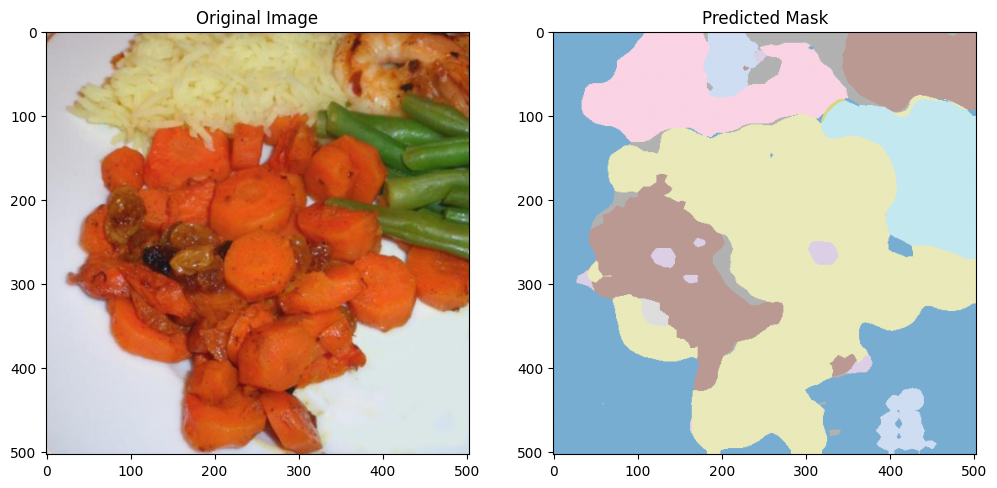

True food items:       ['French beans', 'rice', 'dried cranberries', 'carrot', 'shrimp']
Predicted food items:  ['French beans', 'rice', 'potato', 'ice cream', 'tomato', 'steak', 'pork', 'chicken duck', 'lettuce', 'sauce', 'carrot', 'asparagus', 'cilantro mint', 'onion']
Food Accuracy:        18.75%
Pixel Accuracy:       75.57%
Mean IoU:             19.26%
Mean Dice:            3.45%
Avg. Hausdorff Dist.: 76.65 pixels

Processing sample 2/10


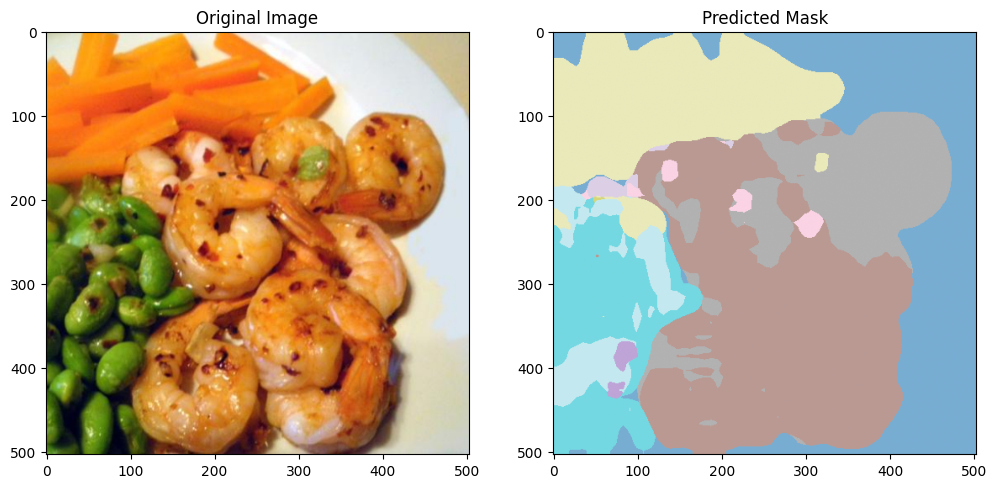

True food items:       ['shrimp', 'carrot', 'green beans']
Predicted food items:  ['pasta', 'noodles', 'rice', 'potato', 'rape', 'cucumber', 'carrot', 'asparagus', 'broccoli', 'cilantro mint', 'green beans', 'French beans', 'grape', 'steak', 'pork', 'chicken duck']
Food Accuracy:        11.76%
Pixel Accuracy:       39.70%
Mean IoU:             11.33%
Mean Dice:            2.18%
Avg. Hausdorff Dist.: 42.05 pixels

Processing sample 3/10


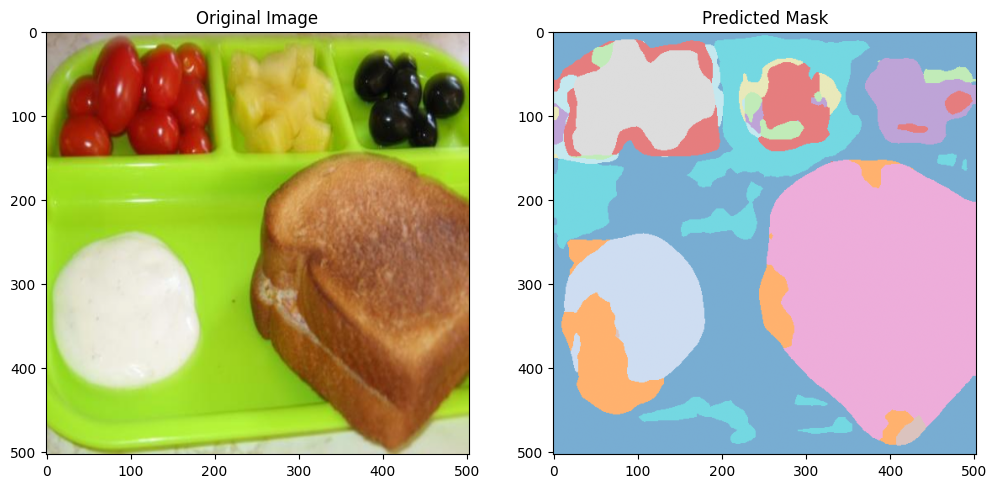

True food items:       ['olives', 'pineapple', 'tomato', 'sauce', 'bread']
Predicted food items:  ['ice cream', 'tomato', 'cake', 'milkshake', 'juice', 'cucumber', 'celery stick', 'apple', 'banana', 'strawberry', 'pepper', 'blueberry', 'pear', 'pineapple', 'grape', 'kiwi', 'sauce', 'bread']
Food Accuracy:        21.05%
Pixel Accuracy:       61.89%
Mean IoU:             11.72%
Mean Dice:            2.56%
Avg. Hausdorff Dist.: 106.51 pixels

Processing sample 4/10


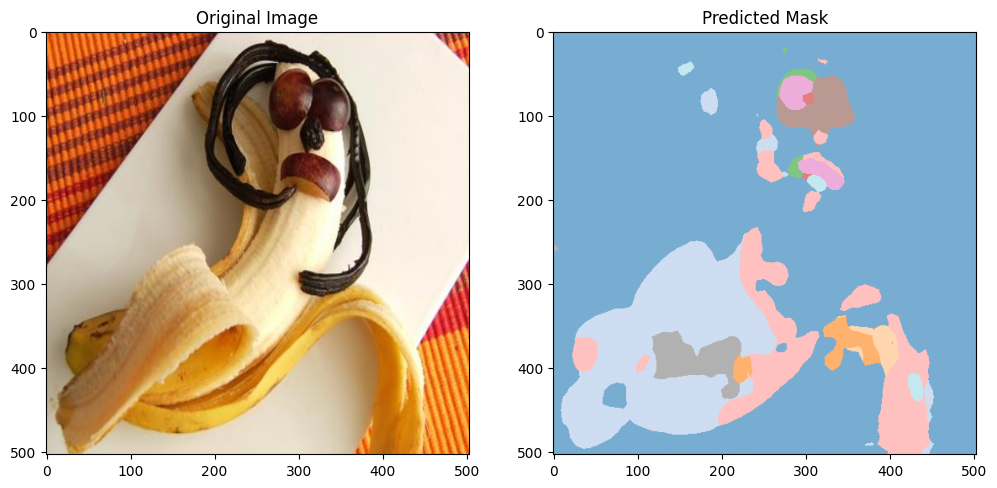

True food items:       ['grape', 'chocolate', 'banana']
Predicted food items:  ['biscuit', 'cake', 'milkshake', 'coffee', 'juice', 'milk', 'almond', 'pumpkin', 'apple', 'banana', 'cherry', 'blueberry', 'grape', 'orange', 'sausage', 'bread']
Food Accuracy:        11.76%
Pixel Accuracy:       65.78%
Mean IoU:             7.57%
Mean Dice:            1.71%
Avg. Hausdorff Dist.: 81.88 pixels

Processing sample 5/10


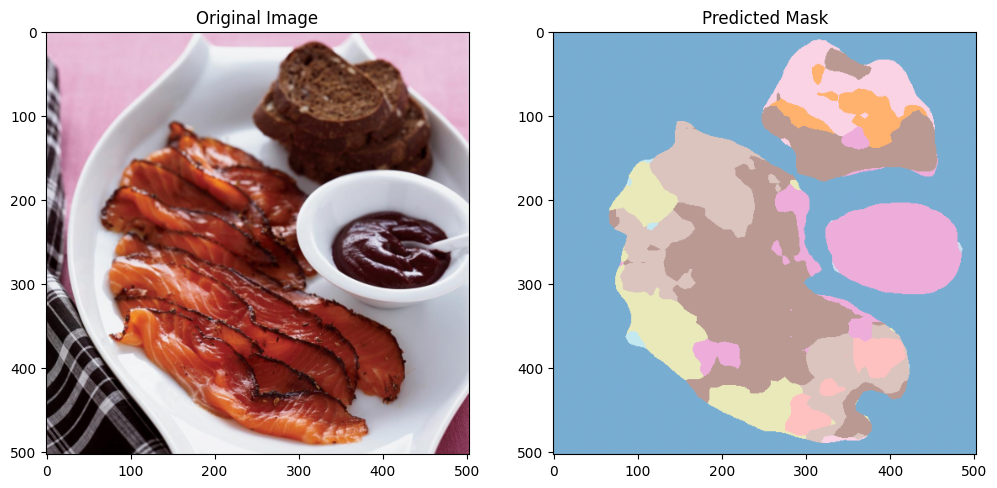

True food items:       ['bread', 'sauce', 'fish']
Predicted food items:  ['ice cream', 'tomato', 'cake', 'steak', 'pork', 'chicken duck', 'sausage', 'lettuce', 'sauce', 'carrot', 'bread', 'strawberry']
Food Accuracy:        15.38%
Pixel Accuracy:       58.99%
Mean IoU:             12.74%
Mean Dice:            2.06%
Avg. Hausdorff Dist.: 283.68 pixels

Processing sample 6/10


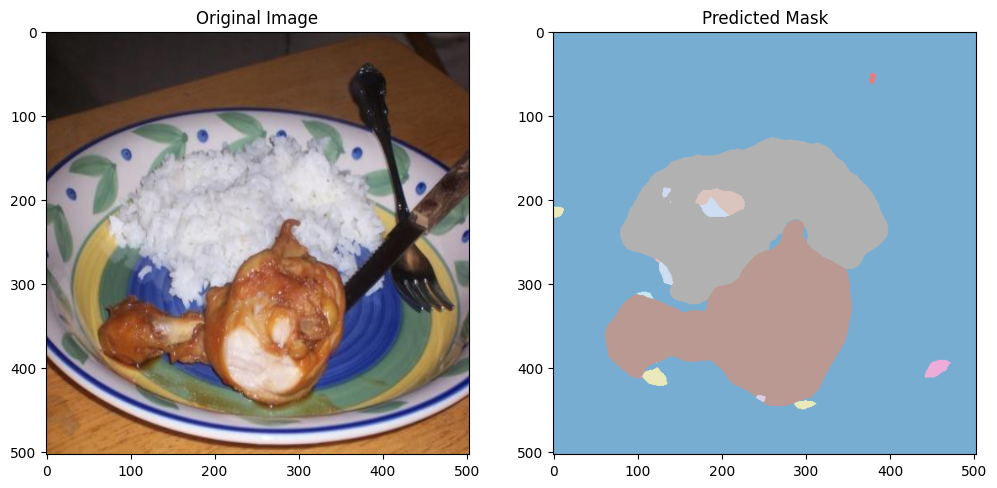

True food items:       ['chicken duck', 'rice']
Predicted food items:  ['blueberry', 'rice', 'ice cream', 'tomato', 'steak', 'chicken duck', 'lettuce', 'sauce', 'bread', 'onion']
Food Accuracy:        20.00%
Pixel Accuracy:       96.42%
Mean IoU:             25.04%
Mean Dice:            2.76%
Avg. Hausdorff Dist.: 18.26 pixels

Processing sample 7/10


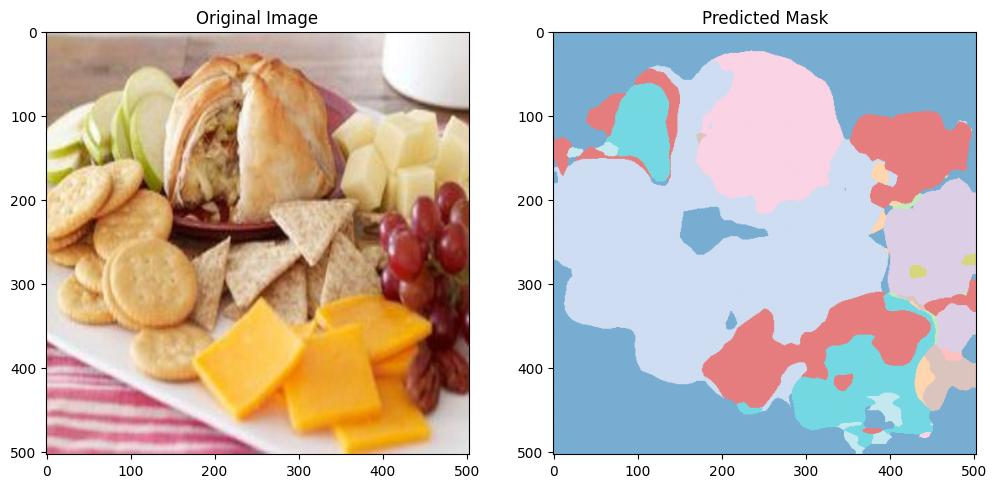

True food items:       ['biscuit', 'other ingredients', 'cheese butter', 'grape', 'apple', 'bread']
Predicted food items:  ['french fries', 'biscuit', 'tomato', 'almond', 'pumpkin', 'cucumber', 'carrot', 'celery stick', 'apple', 'banana', 'strawberry', 'cherry', 'grape', 'sausage', 'sauce', 'bread', 'corn']
Food Accuracy:        21.05%
Pixel Accuracy:       65.29%
Mean IoU:             14.72%
Mean Dice:            3.25%
Avg. Hausdorff Dist.: 171.25 pixels

Processing sample 8/10


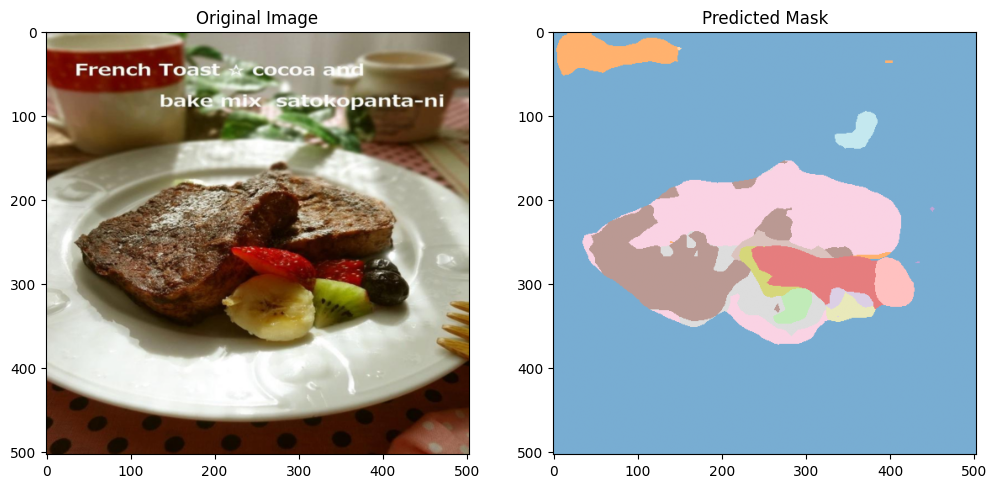

True food items:       ['blueberry', 'kiwi', 'bread', 'banana', 'strawberry']
Predicted food items:  ['pie', 'tomato', 'cake', 'wine', 'coffee', 'juice', 'lettuce', 'egg', 'cilantro mint', 'strawberry', 'cherry', 'blueberry', 'raspberry', 'lemon', 'kiwi', 'steak', 'chicken duck', 'sauce', 'bread']
Food Accuracy:        20.00%
Pixel Accuracy:       85.83%
Mean IoU:             14.93%
Mean Dice:            3.54%
Avg. Hausdorff Dist.: 39.00 pixels

Processing sample 9/10


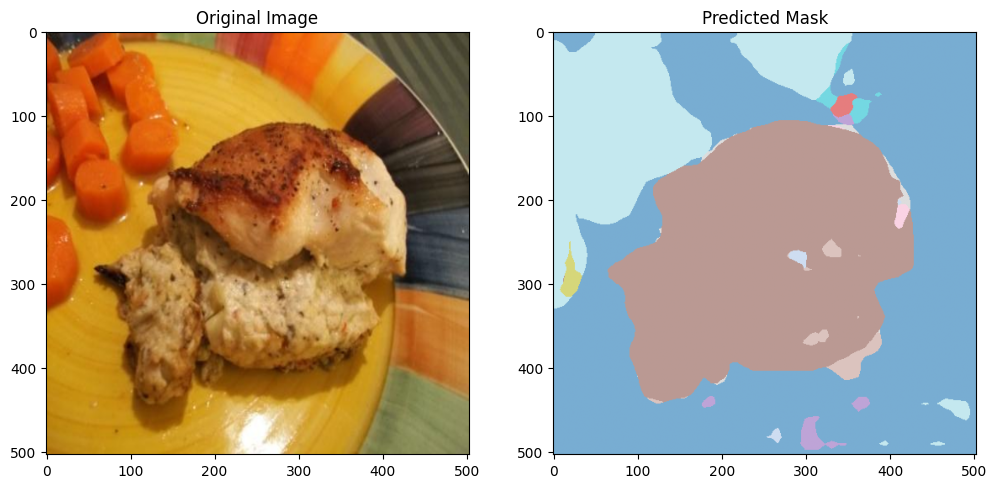

True food items:       ['chicken duck', 'carrot']
Predicted food items:  ['lemon', 'potato', 'ice cream', 'tomato', 'orange', 'steak', 'chicken duck', 'pumpkin', 'sauce', 'carrot', 'celery stick', 'bread', 'banana']
Food Accuracy:        15.38%
Pixel Accuracy:       83.77%
Mean IoU:             15.95%
Mean Dice:            2.45%
Avg. Hausdorff Dist.: 138.68 pixels

Processing sample 10/10


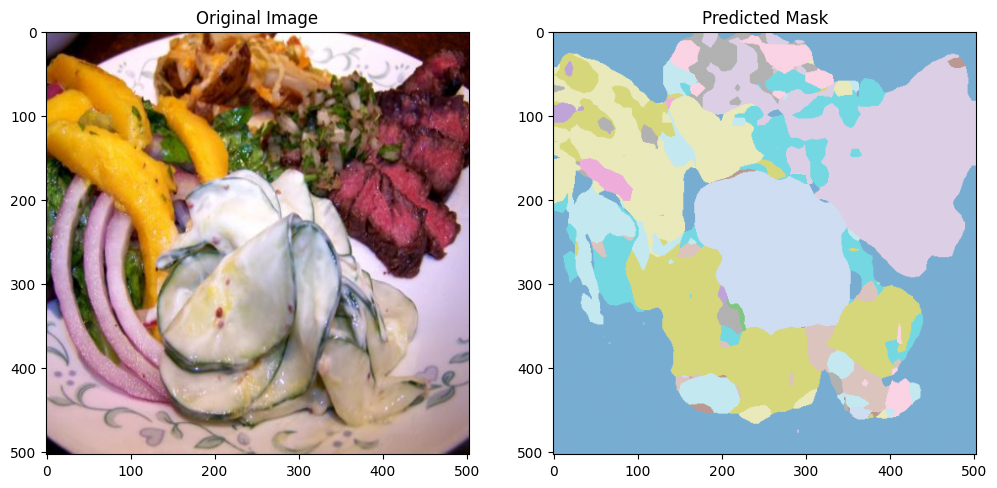

True food items:       ['shiitake', 'other ingredients', 'steak', 'cucumber', 'cilantro mint', 'onion']
Predicted food items:  ['biscuit', 'ice cream', 'egg', 'pineapple', 'orange', 'steak', 'pork', 'chicken duck', 'sausage', 'sauce', 'shellfish', 'shrimp', 'corn', 'pasta', 'noodles', 'rice', 'potato', 'tomato', 'lettuce', 'pumpkin', 'cucumber', 'carrot', 'asparagus', 'broccoli', 'celery stick', 'cilantro mint', 'onion', 'pepper', 'green beans', 'French beans', 'shiitake']
Food Accuracy:        15.62%
Pixel Accuracy:       49.02%
Mean IoU:             6.69%
Mean Dice:            2.79%
Avg. Hausdorff Dist.: 221.15 pixels

Overall Performance Metrics:
Avg. Pixel Accuracy: 68.23%
Avg. Mean IoU:       13.99%
Avg. Mean Dice:      2.67%
Avg. Hausdorff Dist.: 117.91 pixels


In [ ]:
# Evaluation Code
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import transforms
from matplotlib.colors import ListedColormap
import torch.nn as nn
from pyarrow.parquet import ParquetFile
from scipy.spatial.distance import directed_hausdorff

# -------------------------------------------------------
# Updated Hyperparameters (using the training scale factor)
# -------------------------------------------------------
BASE_SIZE = 513
IMG_SCALE = 0.9802857225639665
IMG_SIZE = (int(round(BASE_SIZE * IMG_SCALE)), int(round(BASE_SIZE * IMG_SCALE)))
HYPERPARAMS = {
    "img_size": IMG_SIZE,    # effective image size computed as in training
    "num_classes": 104,      # Number of segmentation classes
}

# Load class mappings CSV.
class_mappings = pd.read_csv('/content/foodseg103/class_mappings.csv')
id_to_food = dict(zip(class_mappings["Class Id"], class_mappings["Class Name"]))

def load_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Load DeepLabV3 with ResNet-50 backbone; use pretrained weights to match training.
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)
    # Replace the final classifier layer.
    model.classifier[4] = nn.Conv2d(256, HYPERPARAMS["num_classes"], kernel_size=1)
    # Load the best model saved from training.
    state_dict = torch.load("/content/foodseg103/best_deeplabv3_resnet50_foodseg103.pth", map_location=device)
    model.load_state_dict(state_dict, strict=False)
    model.to(device)
    model.eval()
    return model, device

# Define the image transform using the updated image size.
img_transform = transforms.Compose([
    transforms.Resize(HYPERPARAMS["img_size"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

def compute_segmentation_metrics(pred, target, num_classes):
    pred, target = pred.flatten(), target.flatten()
    pixel_acc = np.mean(pred == target)
    iou_list, dice_list = [], []
    for cls in range(num_classes):
        pred_inds, target_inds = (pred == cls), (target == cls)
        intersection, union = np.sum(pred_inds & target_inds), np.sum(pred_inds | target_inds)
        iou = np.nan if union == 0 else intersection / union
        dice = (2 * intersection) / (np.sum(pred_inds) + np.sum(target_inds) + 1e-8)
        iou_list.append(iou)
        dice_list.append(dice)
    return pixel_acc, np.nanmean(iou_list), np.nanmean(dice_list)

def hausdorff_distance_for_class(pred, target, cls):
    pred_points, target_points = np.argwhere(pred == cls), np.argwhere(target == cls)
    if pred_points.size == 0 or target_points.size == 0:
        return np.nan
    return max(directed_hausdorff(pred_points, target_points)[0],
               directed_hausdorff(target_points, pred_points)[0])

def compute_average_hausdorff(pred, target, num_classes):
    hd_list = [hausdorff_distance_for_class(pred, target, cls) for cls in range(1, num_classes)]
    valid_hd = [hd for hd in hd_list if not np.isnan(hd)]
    return np.nanmean(valid_hd) if valid_hd else np.nan

def stream_validation_data():
    return ParquetFile("/content/foodseg103/validation-00000-of-00001-a5bfdaa5beb7006a.parquet").iter_batches(batch_size=1)

def process_image(batch, model, device, id_to_food):
    # Load and process the input image and ground-truth mask.
    img = Image.open(io.BytesIO(batch['image'][0].as_py()['bytes'])).convert("RGB")
    gt_mask = np.array(Image.open(io.BytesIO(batch['label'][0].as_py()['bytes'])).resize(HYPERPARAMS["img_size"], Image.NEAREST))

    true_ids = set(np.unique(gt_mask)) - {0}
    true_foods = [id_to_food.get(fid, "Unknown") for fid in true_ids if fid in id_to_food]

    # Transform the image.
    input_tensor = img_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor)['out'][0].argmax(0).cpu().numpy()

    pred_ids = set(np.unique(pred_mask)) - {0}

    # --- Updated Food Accuracy Calculation ---
    # If there are no true food items, then we assign 100% if no predictions are made.
    if not true_ids:
        food_accuracy = 100.0 if not pred_ids else 0.0
    else:
        union_ids = true_ids | pred_ids
        intersection_ids = true_ids & pred_ids
        food_accuracy = (len(intersection_ids) / len(union_ids)) * 100.0

    pixel_acc, mean_iou, mean_dice = compute_segmentation_metrics(pred_mask, gt_mask, HYPERPARAMS["num_classes"])
    avg_hausdorff = compute_average_hausdorff(pred_mask, gt_mask, HYPERPARAMS["num_classes"])

    predicted_foods = [id_to_food.get(pid, "Unknown") for pid in pred_ids if pid in id_to_food]
    return img, input_tensor, pred_mask, gt_mask, true_foods, predicted_foods, food_accuracy, pixel_acc, mean_iou, mean_dice, avg_hausdorff

def main():
    model, device = load_model()
    val_stream = stream_validation_data()
    cmap = ListedColormap(plt.cm.tab20.colors[:HYPERPARAMS["num_classes"]])
    overall_metrics = {"pixel_acc": [], "mean_iou": [], "mean_dice": [], "hausdorff": []}

    for i, batch in enumerate(val_stream):
        if i >= 10:
            break
        print(f"\nProcessing sample {i+1}/10")
        img, img_tensor, pred_mask, gt_mask, true_foods, predicted_foods, food_acc, pix_acc, mean_iou, mean_dice, hausdorff = process_image(batch, model, device, id_to_food)
        overall_metrics["pixel_acc"].append(pix_acc)
        overall_metrics["mean_iou"].append(mean_iou)
        overall_metrics["mean_dice"].append(mean_dice)
        overall_metrics["hausdorff"].append(hausdorff)

        # Denormalize the image for display.
        img_denorm = img_tensor.squeeze(0) * torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1) \
                     + torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
        img_np = np.clip(img_denorm.permute(1, 2, 0).cpu().numpy(), 0, 1)

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_np)
        ax[0].set_title("Original Image")
        ax[1].imshow(pred_mask, cmap=cmap, alpha=0.6)
        ax[1].set_title("Predicted Mask")
        plt.show()
        print("True food items:      ", true_foods)
        print("Predicted food items: ", predicted_foods)
        print(f"Food Accuracy:        {food_acc:.2f}%")
        print(f"Pixel Accuracy:       {pix_acc*100:.2f}%")
        print(f"Mean IoU:             {mean_iou*100:.2f}%")
        print(f"Mean Dice:            {mean_dice*100:.2f}%")
        print(f"Avg. Hausdorff Dist.: {hausdorff:.2f} pixels")

    print("\nOverall Performance Metrics:")
    print(f"Avg. Pixel Accuracy: {np.mean(overall_metrics['pixel_acc'])*100:.2f}%")
    print(f"Avg. Mean IoU:       {np.mean(overall_metrics['mean_iou'])*100:.2f}%")
    print(f"Avg. Mean Dice:      {np.mean(overall_metrics['mean_dice'])*100:.2f}%")
    print(f"Avg. Hausdorff Dist.: {np.nanmean(overall_metrics['hausdorff']):.2f} pixels")

if __name__ == "__main__":
    main()


In [ ]:
!xxd /content/foodseg103/deeplabv3_resnet50_foodseg103.pth | head

00000000: ca5c 08ba 5226 f8bb 30bf 8c3b 7284 ee3a  .\..R&..0..;r..:
00000010: 4b08 363a 9c5a 0dbc d7df bc3b 4bc1 04bc  K.6:.Z.....;K...
00000020: 48ad 71bb c612 e13b 30ae 0f39 6c4f 00bc  H.q....;0..9lO..
00000030: 7648 0d3c d012 a6bb 005a ab3a 033a b739  vH.<.....Z.:.:.9
00000040: 5ad2 943c b9fb 4d3a 1d7d eabb 2cfd 87b9  Z..<..M:.}..,...
00000050: 92cf 9ebc edb0 ddba 9393 483b 6106 b03b  ..........H;a..;
00000060: 1f9c ef3a 2843 63bb 85f3 82ba 7268 ddbb  ...:(Cc.....rh..
00000070: ab01 adbb 9c31 ea3a b271 f23a 69ef 14bc  .....1.:.q.:i...
00000080: bd75 15bc c581 5c3c cc97 ffbb 5df0 b2ba  .u....\<....]...
00000090: 2806 6339 07bd 78bc a957 233b 4bcd d63b  (.c9..x..W#;K..;
